# Access CMIP6 zarr data from AWS using the osdf protocol and compute Equilibrium Climate Sensitivity (ECS)
- This workflow is an adaptation of https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/ECS_Gregory_method.html
- We use the [Gregory method](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2003GL018747) to compute ECS

## Table of Contents
- [Section 1: Introduction](#Section-1:-Introduction) 
- [Section 2: Select Dask Cluster](#Section-2:-Select-Dask-Cluster) 
- [Section 3: Data Loading](#Section-3:-Data-Loading) 
- [Section 4: Data Analysis](#Section-4:-Data-Analysis) 

## Section 1: Introduction
- Load python packkages
- Load catalog url

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
import re
import aiohttp
from dask_jobqueue import PBSCluster
import pandas as pd
from xhistogram.xarray import histogram

/glade/derecho/scratch/harshah/tmp/ipykernel_55452/3451259092.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# import fsspec.implementations.http as fshttp
from pelicanfs.core import OSDFFileSystem,PelicanMap 

In [3]:
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
cat_url     = rda_url +  'd850001/catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json'
# cat_url     = 'https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json'

## Section 2: Select Dask Cluster

#### Select the Dask cluster type
The default will be LocalCluster as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [4]:
USE_PBS_SCHEDULER = True

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [5]:
USE_DASK_GATEWAY = False

#### Python function for a PBS cluster

In [6]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = rda_scratch + '/dask/spill',
        log_directory = rda_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

#### Python function for a Gateway Cluster

In [7]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

In [8]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(6)
    return cluster

#### Python logic for a Local Cluster
This uses True/False boolean logic based on the variables set in the previous cells

In [9]:
# Obtain dask cluster in one of three ways
if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46315 instead
  warnings.warn(


In [10]:
# Scale the cluster and display cluster dashboard URL
n_workers =8
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(0158eac9, 'tcp://128.117.208.94:38723', workers=8, threads=8, memory=32.00 GiB)

## Section 3: Data Loading
- Load catalog and select data subset

In [11]:
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [12]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp585',
 'ssp245',
 'ssp370-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'ssp370SST-lowCH4',
 'ssp370SST-lowNTCF',
 'ssp126',
 'ssp119',
 'ssp370',
 'esm-ssp585',
 'ssp245-nat',
 'ssp245-GHG',
 'ssp460',
 'ssp434',
 'ssp534-over',
 'ssp245-aer',
 'ssp245-stratO3',
 'ssp245-cov-fossil',
 'ssp245-cov-modgreen',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-bgc']

In [13]:
query = dict(
    experiment_id=['abrupt-4xCO2','piControl'], # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',                            # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=['tas', 'rsut','rsdt','rlut'],  # choose to look at near-surface air temperature (tas) as our variable
    member_id = 'r1i1p1f1',                     # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,2,4,1
ACCESS-ESM1-5,2,4,1
AWI-CM-1-1-MR,2,4,1
BCC-CSM2-MR,2,4,1
BCC-ESM1,2,4,1
CAMS-CSM1-0,2,4,1
CAS-ESM2-0,2,4,1
CESM2,2,4,1
CESM2-FV2,2,4,1


In [14]:
def drop_all_bounds(ds):
    """Drop coordinates like 'time_bounds' from datasets,
    which can lead to issues when merging."""
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop_vars(drop_vars)

def open_dsets(df):
    """Open datasets from cloud storage and return xarray dataset."""
    dsets = [xr.open_zarr(fsspec.get_mapper(ds_url), consolidated=True)
             .pipe(drop_all_bounds)
             for ds_url in df.zstore]
    try:
        ds = xr.merge(dsets, join='exact')
        return ds
    except ValueError:
        return None

def open_delayed(df):
    """A dask.delayed wrapper around `open_dsets`.
    Allows us to open many datasets in parallel."""
    return dask.delayed(open_dsets)(df)

In [15]:
from collections import defaultdict

dsets = defaultdict(dict)
for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [16]:
%time open_dsets(df)

CPU times: user 676 ms, sys: 43.3 ms, total: 719 ms
Wall time: 952 ms


<xarray.Dataset> Size: 5GB
Dimensions:  (lat: 192, lon: 288, time: 6000)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 48kB 0201-01-16 12:00:00 ... 0700-12-16 12:00:00
    height   float64 8B ...
Data variables:
    rsut     (time, lat, lon) float32 1GB dask.array<chunksize=(328, 192, 288), meta=np.ndarray>
    rsdt     (time, lat, lon) float32 1GB dask.array<chunksize=(498, 192, 288), meta=np.ndarray>
    tas      (time, lat, lon) float32 1GB dask.array<chunksize=(407, 192, 288), meta=np.ndarray>
    rlut     (time, lat, lon) float32 1GB dask.array<chunksize=(355, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             branch-restart from year 0201-01-01 of piContr...
    branch_time:               0.0
    branch_time_in_child:      430335.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     TaiESM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/cd4ff0f0-e4b1-4158-b18b-1d8f071cb...
    variable_id:               rsut
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/cd4ff0f0-e4b1-4158-b18b-1d8f071cb...
    version_id:                v20200211

In [17]:
dsets_ = dask.compute(dict(dsets))[0]

## Section 4: Data Analysis
- Reduce data via Global Mean
- Grab some observations ?

In [18]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [19]:
expts = ['piControl', 'abrupt-4xCO2']
expt_da = xr.DataArray(expts, dims='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year - ds.time.dt.year[0]

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean).swap_dims({'time': 'year'}).drop_vars('time').coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='right',dim=expt_da)

  0%|          | 0/41 [00:00<?, ?it/s]

Missing experiment for ACCESS-ESM1-5
Missing experiment for CAS-ESM2-0
Missing experiment for EC-Earth3-Veg
Missing experiment for FIO-ESM-2-0
Missing experiment for GFDL-CM4
Missing experiment for MPI-ESM-1-2-HAM


In [20]:
%%time
dsets_aligned_ = dask.compute(dsets_aligned)[0]

CPU times: user 15.5 s, sys: 839 ms, total: 16.3 s
Wall time: 1min 36s


In [21]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id',coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True) for ds in dsets_aligned_.values()],
                   dim=source_da)
big_ds

<xarray.Dataset> Size: 2MB
Dimensions:        (source_id: 35, experiment_id: 2, year: 999)
Coordinates:
  * year           (year) float64 8kB 0.0 1.0 2.0 3.0 ... 996.0 997.0 998.0
  * experiment_id  (experiment_id) <U12 96B 'piControl' 'abrupt-4xCO2'
  * source_id      (source_id) <U17 2kB 'ACCESS-CM2' ... 'TaiESM1'
Data variables:
    rlut           (source_id, experiment_id, year) float64 559kB 242.2 ... nan
    tas            (source_id, experiment_id, year) float64 559kB 287.0 ... nan
    rsut           (source_id, experiment_id, year) float64 559kB 97.84 ... nan
    rsdt           (source_id, experiment_id, year) float64 559kB 340.4 ... nan

### Calculated Derived Variables

In [22]:
big_ds['imbalance'] = big_ds['rsdt'] - big_ds['rsut'] - big_ds['rlut']

ds_mean = big_ds[['tas', 'imbalance']].sel(experiment_id='piControl').mean(dim='year')
ds_anom = big_ds[['tas', 'imbalance']] - ds_mean

# add some metadata
ds_anom.tas.attrs['long_name'] = 'Global Mean Surface Temp Anom'
ds_anom.tas.attrs['units'] = 'K'
ds_anom.imbalance.attrs['long_name'] = 'Global Mean Radiative Imbalance'
ds_anom.imbalance.attrs['units'] = 'W m$^{-2}$'

ds_anom

<xarray.Dataset> Size: 1MB
Dimensions:        (year: 999, experiment_id: 2, source_id: 35)
Coordinates:
  * year           (year) float64 8kB 0.0 1.0 2.0 3.0 ... 996.0 997.0 998.0
  * experiment_id  (experiment_id) <U12 96B 'piControl' 'abrupt-4xCO2'
  * source_id      (source_id) <U17 2kB 'ACCESS-CM2' ... 'TaiESM1'
Data variables:
    tas            (source_id, experiment_id, year) float64 559kB -0.03737 .....
    imbalance      (source_id, experiment_id, year) float64 559kB -0.04809 .....

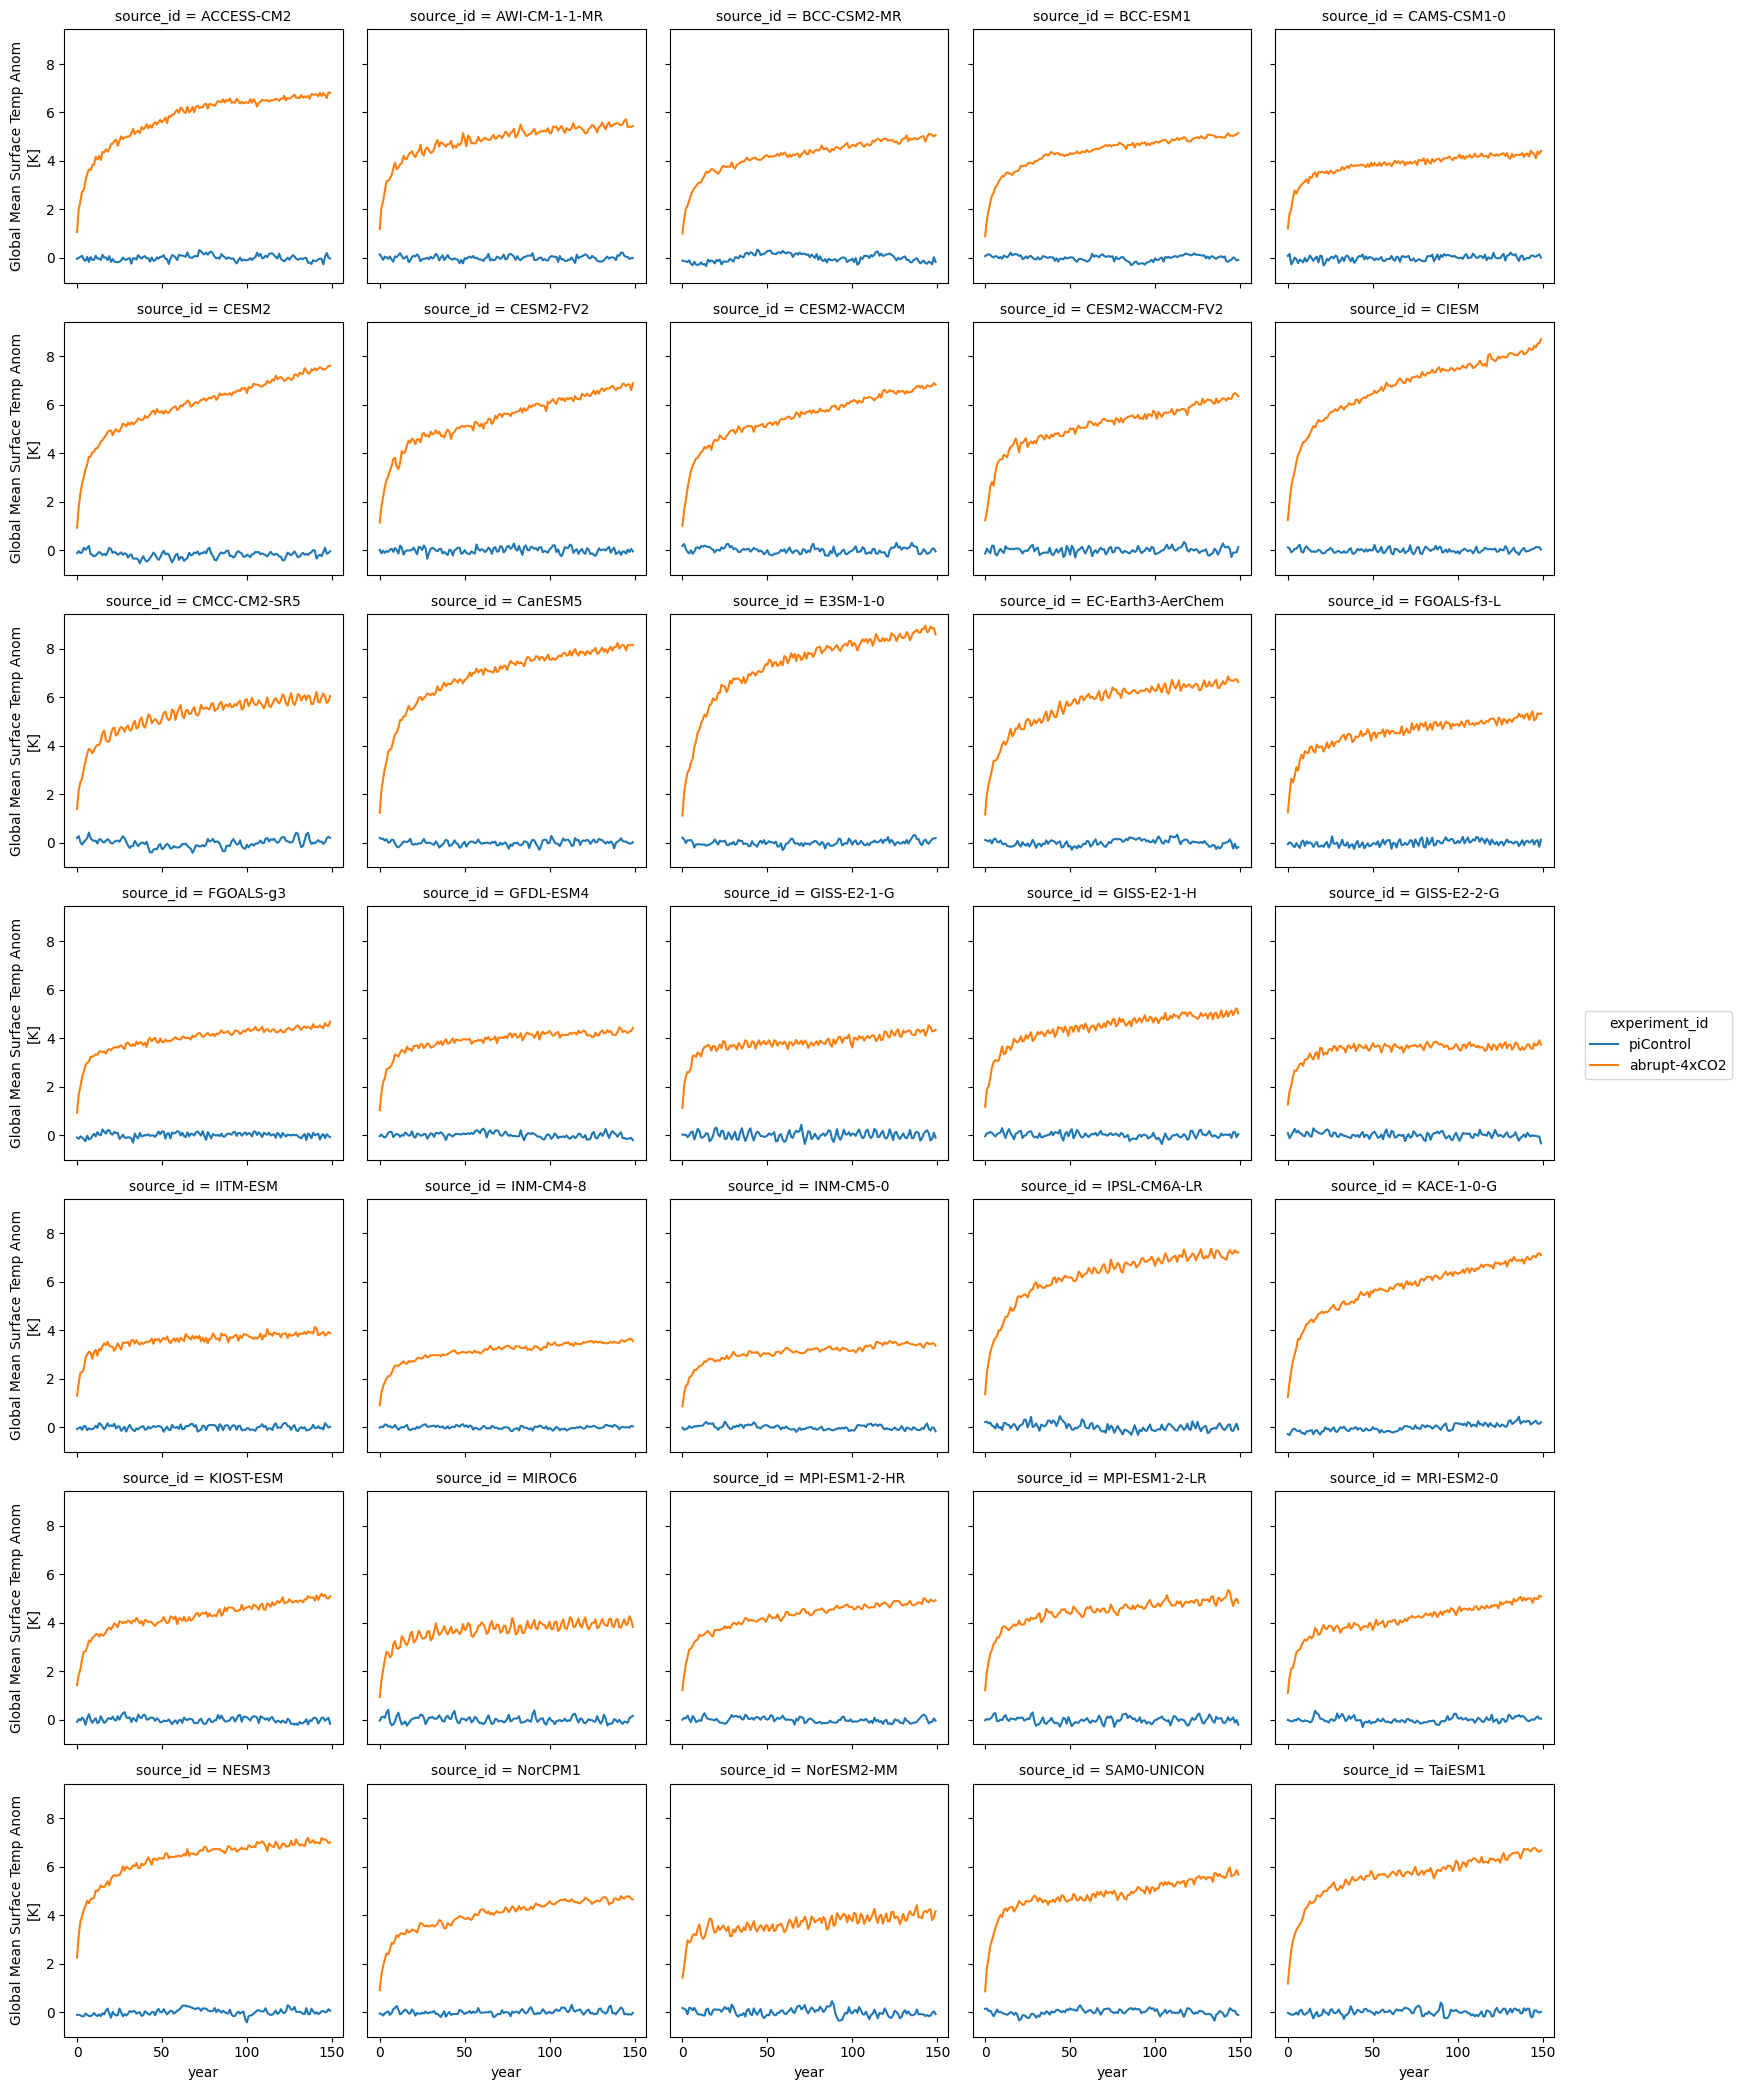

In [23]:
# limit to the gregory 150-year period
first_150_years = slice(0, 149)
ds_anom.tas.sel(year=first_150_years).plot.line(col='source_id', x='year', col_wrap=5)

### Calculate ECS

In [30]:
ds_abrupt = ds_anom.sel(year=first_150_years, experiment_id='abrupt-4xCO2').reset_coords(drop=True)

In [32]:
def calc_ecs(ds):
    tas_1d = ds.tas.squeeze()
    imbalance_1d = ds.imbalance.squeeze()

    # Align and drop NaNs
    tas_1d, imbalance_1d = xr.align(tas_1d.dropna('year'), imbalance_1d.dropna('year'), join='inner')

    a, b = np.polyfit(tas_1d.values, imbalance_1d.values, 1)
    ecs = -0.5 * (b / a)
    return xr.DataArray(ecs, attrs={'units': 'K'})

In [33]:
ds_abrupt['ecs'] = ds_abrupt.groupby('source_id').apply(calc_ecs)
ds_abrupt

<xarray.Dataset> Size: 88kB
Dimensions:    (year: 150, source_id: 35)
Coordinates:
  * year       (year) float64 1kB 0.0 1.0 2.0 3.0 ... 146.0 147.0 148.0 149.0
  * source_id  (source_id) <U17 2kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
Data variables:
    tas        (source_id, year) float64 42kB 1.071 2.014 2.323 ... 6.619 6.673
    imbalance  (source_id, year) float64 42kB 7.382 6.014 5.277 ... 2.143 2.141
    ecs        (source_id) float64 280B 4.728 3.124 3.021 ... 2.445 3.678 4.35

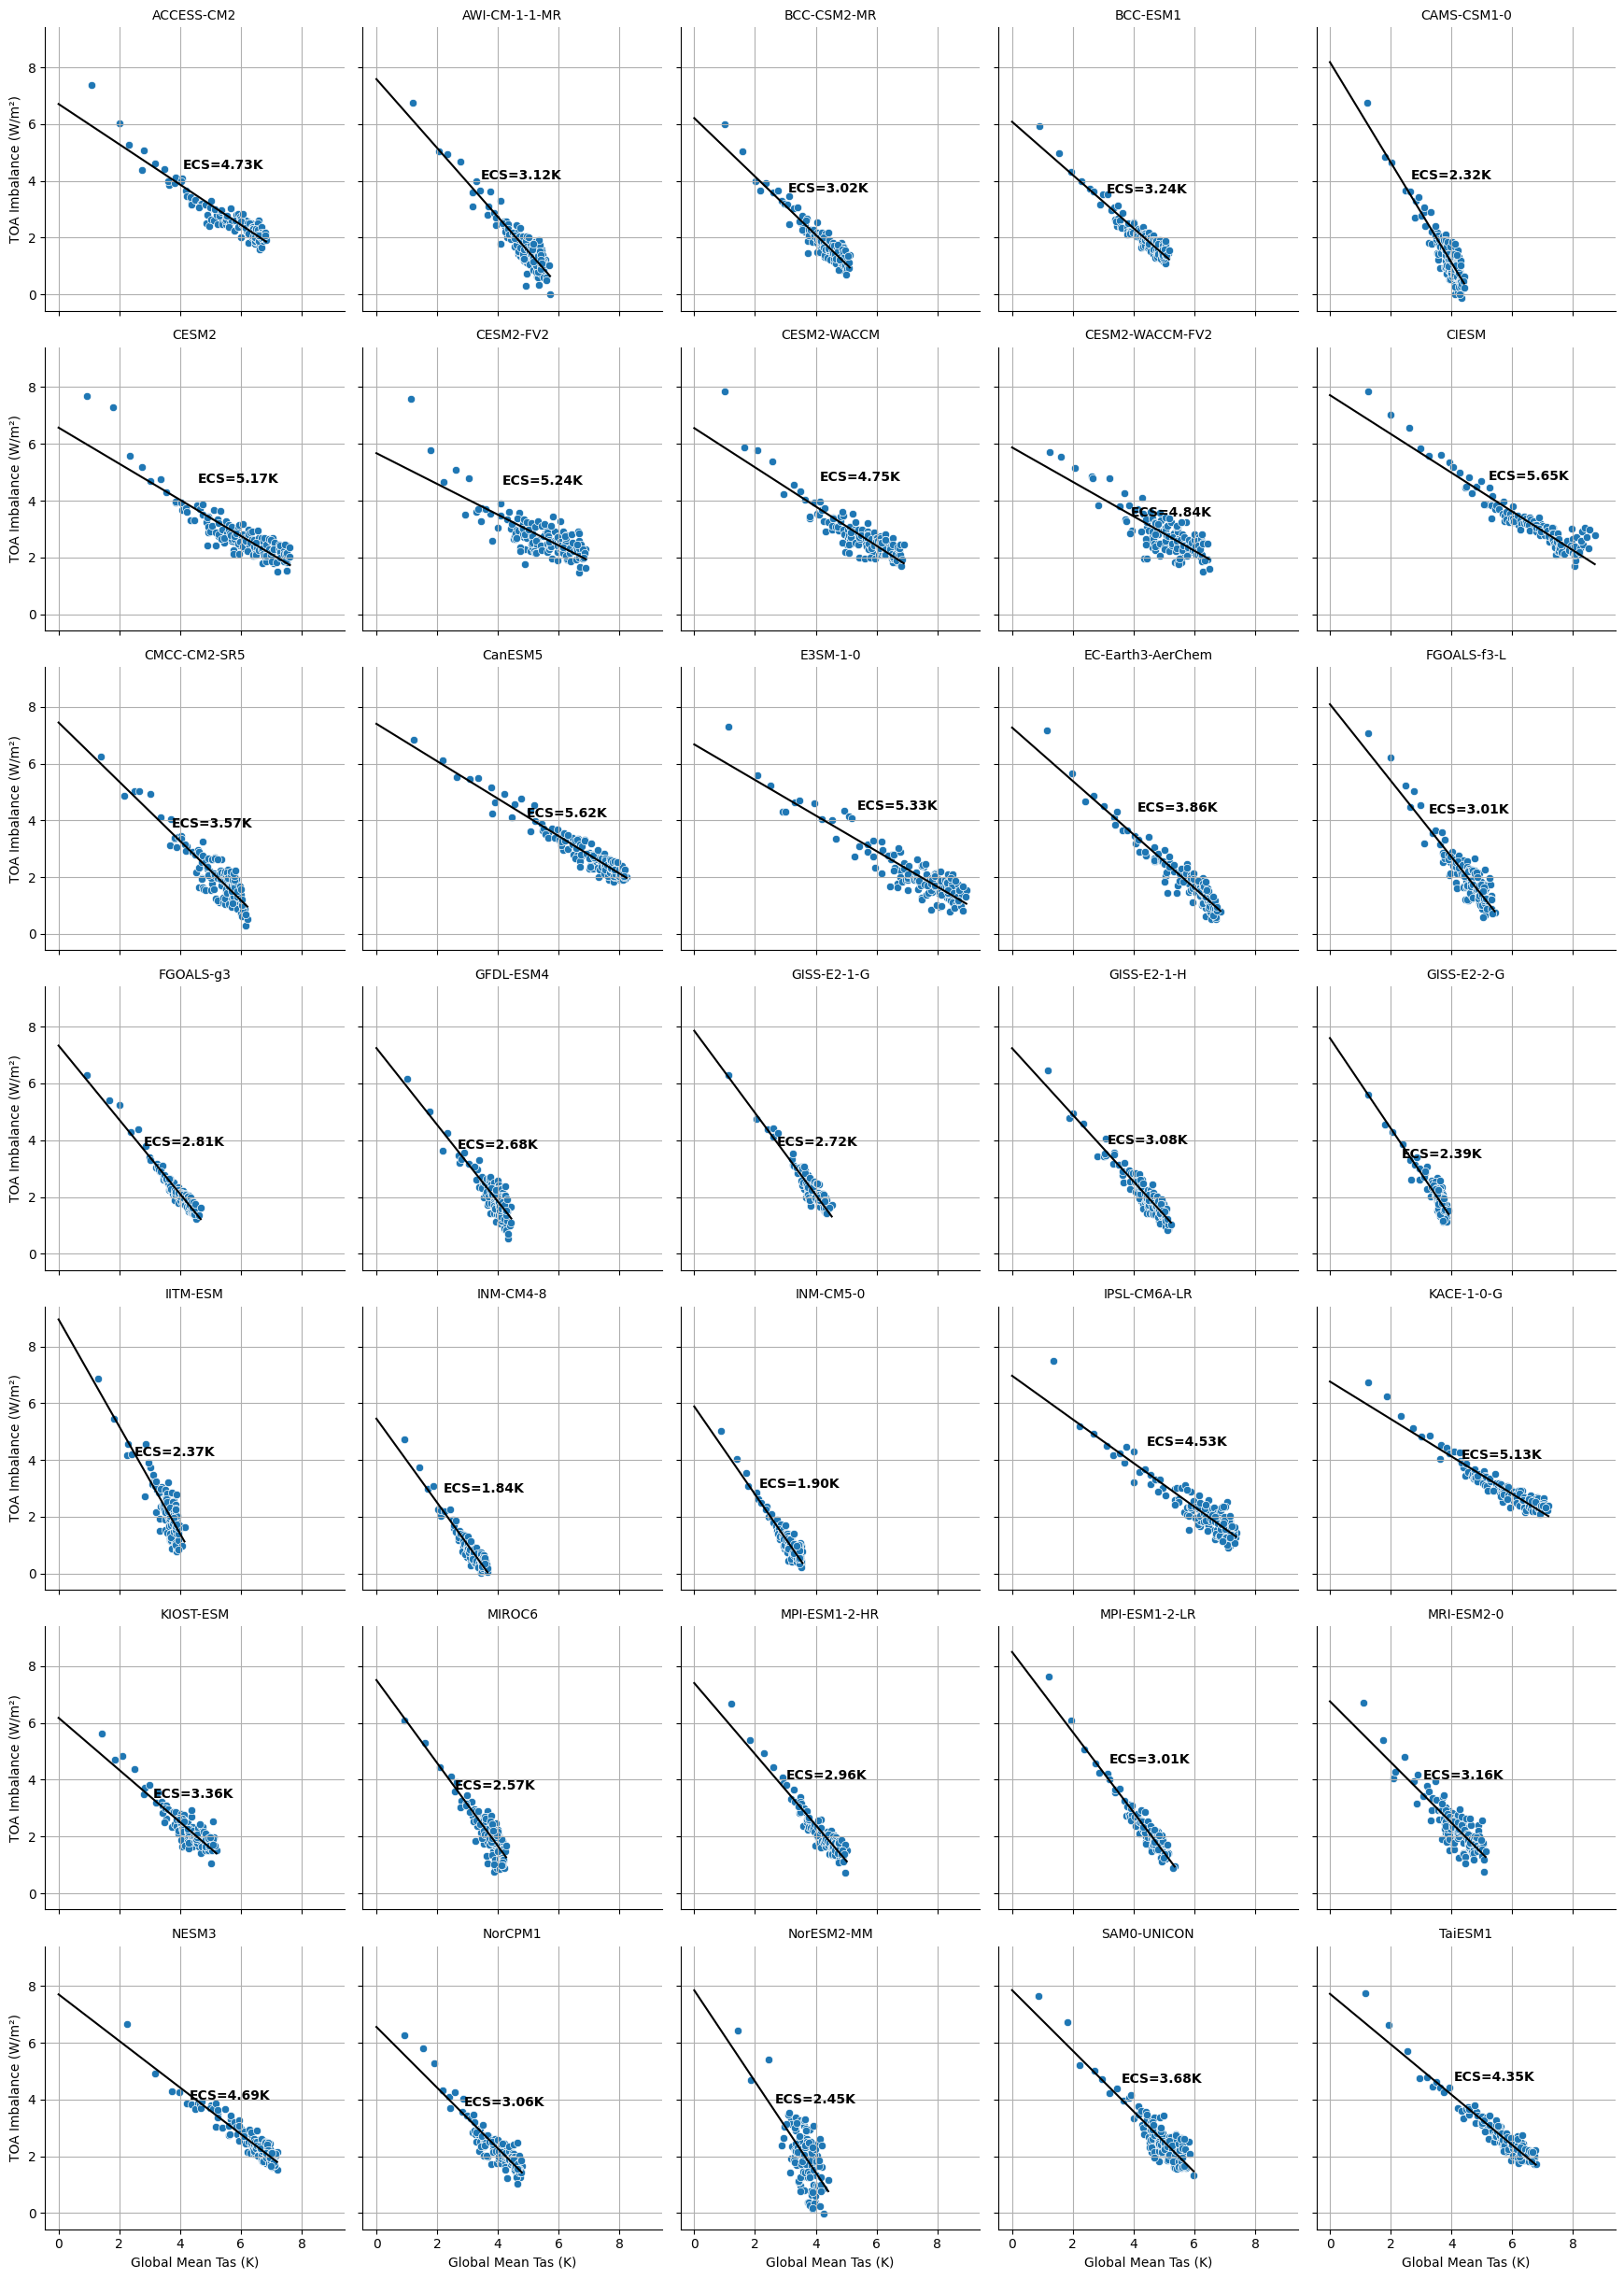

In [35]:
%%time
# Convert to DataFrame
df = ds_abrupt.to_dataframe().reset_index()

# Drop NaNs
df = df.dropna(subset=['tas', 'imbalance'])

# Set up FacetGrid
g = sns.FacetGrid(df, col="source_id", col_wrap=5, height=3.5)
g.map_dataframe(sns.scatterplot, x="tas", y="imbalance")

# Add Gregory fit line and ECS text
def plot_ecs(data, color, **kwargs):
    x = data['tas'].values
    y = data['imbalance'].values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    
    if len(x) < 2:
        return  # skip underpopulated panels
    
    a, b = np.polyfit(x, y, 1)
    ecs = -0.5 * b / a
    
    x_line = np.array([0, x.max()])
    y_line = np.polyval([a, b], x_line)
    
    plt.plot(x_line, y_line, 'k')
    plt.text(0.6 * x.max(), 0.6 * y.max(), f'ECS={ecs:2.2f}K', fontsize=10, weight='bold')
    plt.grid(True)

g.map_dataframe(plot_ecs)

# Optional: adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Global Mean Tas (K)", "TOA Imbalance (W/m²)")
plt.tight_layout()
plt.show()


In [36]:
# fg = ds_abrupt.plot.scatter(x='tas', y='imbalance', col='source_id', col_wrap=5)

# def calc_and_plot_ecs(x, y, **kwargs):
#     x = x[~np.isnan(x)]
#     y = y[~np.isnan(y)]
#     a, b = np.polyfit(x, y, 1)
#     ecs = -0.5 * b/a
#     plt.autoscale(False)
#     plt.plot([0, 10], np.polyval([a, b], [0, 10]), 'k')
#     plt.text(4, 6, f'ECS = {ecs:3.2f}', fontdict={'weight': 'bold', 'size': 12})
#     plt.grid()

# fg.map(calc_and_plot_ecs, 'tas', 'imbalance')

In [37]:
cluster.close()